<a href="https://colab.research.google.com/github/seokiho/kisti-police/blob/main/jsonReader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import torch
import sentencepiece as spm

print(torch.__version__)
print(spm.__version__)

2.0.1+cu118


In [2]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install torch
!pip install sentencepiece
!pip install transformers
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
#!pip install mmcv==2.0.1 -f https://download.openmmlab.com/mmcv/dist/cu118/torch2.0/index.html
!pip uninstall --yes sentencepiece
!pip install --yes sentencepiece==0.1.96

!pip install wget
#!pip install zipfile

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-3gyhn31z/kobert-tokenizer_6ee56cb006394774a0a2d8cdfb2f4aa9
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-3gyhn31z/kobert-tokenizer_6ee56cb006394774a0a2d8cdfb2f4aa9
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
Found existing installation: sentencepiece 0.1.96
Uninstalling sentencepiece-0.1.96:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/sentencepiece-0.1.96.dist-info/*
    /usr/local/lib/python3.10/dist-packages/sentencepiece/*
Proceed (Y/n)? Y
  Successfully uninstalled sentencepiece-0.1.96
  Using cached sentencepiece-0.1.96-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


In [3]:
import os
import re

import csv
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, manhattan_distances, euclidean_distances

from scipy.stats import zscore

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split


/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `sr

In [4]:


# JSON Data structure
#
#   "score": {
#     "-NOhScUFQniRJwhbp85s": {
#       "crm_set": 1,
#       "date_set": 1,
#       "dtime": "15:11:55",
#       "key": "-NOhScUFQniRJwhbp85s",
#       "score_cos": 52.81,
#       "score_lcs": 19.91,
#       "subj_set": 0,
#       "text_con": "2023. 2. 11. 09:30경 장소모르는 곳에서 피해자 김피해에게 아들 이철수라고 하며 카카오톡을 통하여 50만원을 입금해달라고 연락하였다.  이에 속은 피해자는 같은 날 10:20경 김범인 명의 국민은행 계좌(638010064222)로 50만원을 입금하였다.",
#       "whr_set": 1,
#       "word_set": 1
#     },


def json_to_csv(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # exraction list by fields' names
    fields = ["score_cos", "score_lcs", "text_con"]

    with open(output_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(fields)

        for key, item in data["score"].items():  # extract only key of "score" data
            row = [item.get(field, None) for field in fields]
            writer.writerow(row)


# set the files' paths
input_file_path = "/content/gdrive/MyDrive/vltldtkdlxm312-default-rtdb-export.json"
output_file_path = "/content/gdrive/MyDrive/output_all.csv"

# JSON TO CSV
json_to_csv(input_file_path, output_file_path)





####################################################################

                     JSON에서 추출한 데이터 정보

####################################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2350 entries, 0 to 2349
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score_cos  2350 non-null   float64
 1   score_lcs  2350 non-null   float64
 2   text_con   2350 non-null   object 
dtypes: float64(2), object(1)
memory usage: 55.2+ KB


####################################################################

           유사도에 따라 분류 후 데이터프래임(df) 정보

####################################################################




      score_cos  score_lcs                                           text_con  \
0         52.81      19.91  2023. 2. 11. 09:30경 장소모르는 곳에서 피해자 김피해에게 아들 이철수...   
1         52.38      24.67  2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김피해에게 아...   
2         45.02      11.25  피혐의자

<ipython-input-5-2e84d766f813>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.loc[data1['classification'] == 'sentence1', 'sentence2'] = sentence1
<ipython-input-5-2e84d766f813>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.loc[data2['classification'] == 'sentence2', 'sentence2'] = sentence2


<Axes: xlabel='classification', ylabel='count'>

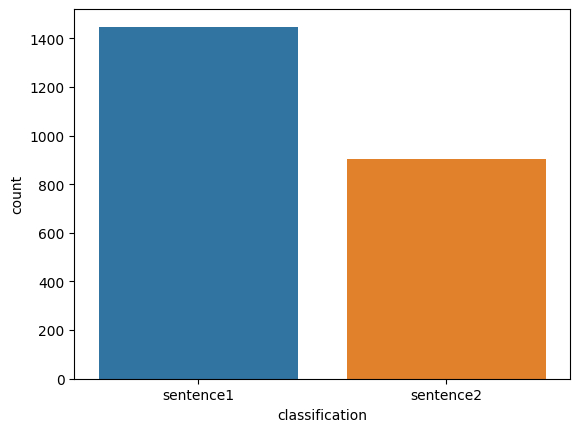

In [5]:

input_csv_file = '/content/gdrive/MyDrive/output_all.csv'

data = pd.read_csv(input_csv_file, encoding="utf-8")


# EDA, no blank truncate data

print("\n\n####################################################################\n")
print("                     JSON에서 추출한 데이터 정보\n")
print("####################################################################\n")

data.info()

# text_con에는 두 가지 시나리오로 구성되므로 라벨링이 필요
# 텍스트 분류 기준은 답안 예시와 유사도 큰 값으로 분류

sentence1 = "피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김피해에게 아들 이철수라고 하며 '급히 돈이 필요한데 휴대폰이 고장나서 OTP가 안되니 대신 송금해주면 집에서 돌려주겠다.'는 카카오톡 메시지를 보냈다. 피혐의자는 아들 이철수를 사칭하여 거짓말하였다. 피혐의자는 이에 속은 피해자로부터 같은 날 10:20경 김범인 명의 국민은행 계좌(638-01-0064-222)로 50만 원 교부받았다."
sentence2 = "피혐의자는 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 피해자 나피해(38세, 여)에게 KB저축은행 대출상담원 김지영 실장으로 속이며 'KB캐피탈 대출'을 상환하면 저금리로 대환할 수 있다고 하였다. 피혐의자는 KB저축은행 앱을 설치하고 대출을 접수하면 심사 후 대출금을 지급해 주겠다고 하면서 원격접속용 앱을 설치하게 하고, 인터넷으로 대출신청서를 작성하게 하였다. 피혐의자는 같은 날 13:30경 '심사 중 대출 상환 위반 사실이 발견되어 기존 대출금을 갚아야 새로운 대출이 가능하다, 금융위원회 직원이 기존 대출금을 회수하러 방문할 테니, 그 직원에게 기존 대출금을 상환하면 된다.'는 취지로 거짓말하였다. 피혐의자는 사실 KB저축은행 직원이 아니었고 피해자에게 저금리 대환대출을 해줄 의사나 능력이 없었다. 피혐의자는 이에 속은 피해자로부터 같은 날 15:20경 충북 충주시 예성로 156에 있는 KB국민은행 충주지점 앞 노상에서 현금 1,580만 원을 교부받았다."

def calculate_text_similarity(input_text, sentence1, sentence2):
    vectorizer = CountVectorizer().fit([input_text, sentence1, sentence2])

    input_vector = vectorizer.transform([input_text])
    vector1 = vectorizer.transform([sentence1])
    vector2 = vectorizer.transform([sentence2])
    similarity1 = cosine_similarity(input_vector, vector1)[0][0]
    similarity2 = cosine_similarity(input_vector, vector2)[0][0]

    return similarity1, similarity2


df = pd.DataFrame(data)

similarities = df.apply(lambda row: calculate_text_similarity(row['text_con'], sentence1,sentence2), axis=1)
df['similarity1'] = similarities.apply(lambda x: x[0])
df['similarity2'] = similarities.apply(lambda x: x[1])

# 'classification'을 추가, 코사인 유사도에 따라 시나리오별(sentence1, sentence2)로 분류
df['classification'] = df.apply(lambda row: 'sentence1' if row['similarity1'] >= row['similarity2'] else 'sentence2', axis=1)


print("\n\n####################################################################\n")
print("           유사도에 따라 분류 후 데이터프래임(df) 정보\n")
print("####################################################################\n\n\n\n")

print(df)

data1 = df[df['classification'] == 'sentence1']
data2 = df[df['classification'] == 'sentence2']


############################################################################
# 훈련 모델에 적용할 데이터를 가공하기 위해 비교대상 텍스트를 컬럼에 삽입  #
############################################################################

data1.loc[data1['classification'] == 'sentence1', 'sentence2'] = sentence1
data2.loc[data2['classification'] == 'sentence2', 'sentence2'] = sentence2

# Sentence1(시나리오 1) : 1,448건
# Sentence2(시나리오 2) :   902건
# 합계 : 총  총 2,350건


print("\n\n\n\n####################################################################\n")
print("                시나리오별(data1, data2) 데이터 정보\n")
print("####################################################################\n")


data1.info()
data2.info()

sns.countplot(data=df, x='classification', order=['sentence1','sentence2'])




In [ ]:
#####################################################################################
# 분류가 잘못되는 결과가 일부 나타남.
# 유사도만으로 분류하지 말고 기계학습을 통한 분류를 구현?
#####################################################################################

# 데이터가 없다..?









####################################################################

                시나리오별(result1, result2) 데이터 정보

####################################################################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text_con              1448 non-null   object 
 1   cosine_similarity     1448 non-null   float64
 2   manhattan_similarity  1448 non-null   float64
 3   euclidean_similarity  1448 non-null   float64
dtypes: float64(3), object(1)
memory usage: 45.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902 entries, 0 to 901
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text_con              902 non-null    object 
 1   cosine_similarity     902 non-null    float64
 2   manhattan_similarity  902

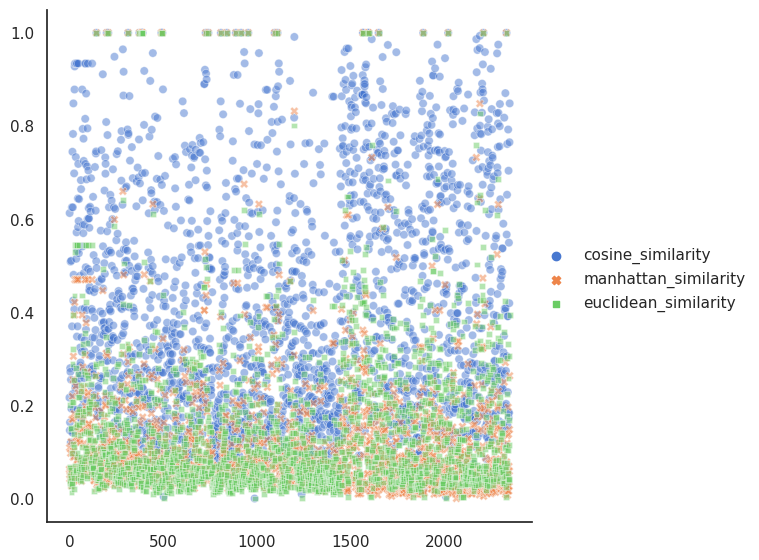

In [6]:



#######################################################################################
# 시나리오 1, 2별로 데이터프래임을 생성하고 각각의 유사도를 산출한다.
#######################################################################################


#"text_con" 컬럼의 문자열 값만 추출
result1 = data1['text_con'].tolist()
result2 = data2['text_con'].tolist()

result1.append(sentence1)
result2.append(sentence2)

def calculate_similarity(data):
    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(data)

    # 코사인 유사도 측정
    cosine_similarities = cosine_similarity(tfidf_matrix)

    # 맨해튼 유사도 측정
    manhattan_similarities = 1 / (1 + manhattan_distances(tfidf_matrix))

    # 유클리드 유사도 측정
    euclidean_similarities = 1 / (1 + euclidean_distances(tfidf_matrix))

    # 결과를 데이터프레임으로 저장
    results = pd.DataFrame({
    'text_con': data,
    'cosine_similarity': cosine_similarities[-1],
    'manhattan_similarity': manhattan_similarities[-1],
    'euclidean_similarity': euclidean_similarities[-1]

    })

    return results

results1 = calculate_similarity(result1)
results2 = calculate_similarity(result2)

#유사도 비교를 위해 append 했던 값은 삭제한다.
results1 = results1.drop(results1.index[-1])
results2 = results2.drop(results2.index[-1])

#results1.pop()
#results2.pop()


print("\n\n\n\n####################################################################\n")
print("                시나리오별(result1, result2) 데이터 정보\n")
print("####################################################################\n")

print(results1.info())
print(results2.info())

print("\n\n\n\n####################################################################\n")
print("                데이터 출력(result1, result2) 데이터 정보\n")
print("####################################################################\n")

print(results1)
print(results2)


# 기존에 산출했던 코사인 유사도와 이번에 산출한 코사인 유사도간 상관관계를 알아본다.

###################################################################################

# 텍스트와 3가지 유사도를 각각 산출한 result1, result2의 데이터 프래임을 병합

results1.reset_index(drop=True, inplace=True)
results2.reset_index(drop=True, inplace=True)
combined_results = pd.concat([results1, results2], ignore_index=True)


print("\n\n\n\n####################################################################\n")
print("            합쳐진 결과 데이터 정보 (combined_results)\n")
print("####################################################################\n")

print(combined_results.info())

print("\n\n\n\n####################################################################\n")
print("            합쳐진 데이터 출력 (combined_results)\n")
print("####################################################################\n")

print(combined_results)

########################################################################################
#                                 유사도별 분포 보기


# 정규화는 데이터의 범위를 [0, 1] 또는 [-1, 1]과 같은 일정한 범위로 변환
# 정규화는 변수의 상대적인 크기를 유지하면서 값 조정. 최소값을 0, 최대값을 1로 맞추는 경우
# MinMaxScaler를 사용. 정규화를 사용하면 변수 간 범위의 차이가 줄어듦.

# 표준화는 데이터의 평균을 0으로, 표준 편차를 1로 만듦. 변수의 분포를 정규 분포에 가깝게 만듦.
# 간단한 예시로, '정규화'는 변수 간 범위를 같게 함. '표준화'는 변수의 평균과 분산을 통제하여 분포를 변환..
#'정규화'는 데이터의 스케일을 조정하고, '표준화'는 데이터의 분포를 변환하여 모델의 성능 향상을 목적.


subset_columns = ['cosine_similarity', 'manhattan_similarity', 'euclidean_similarity']
subset_df = combined_results[subset_columns]

# 표준화 (Standardization)
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(subset_df)
# df_standardized = pd.DataFrame(scaled_data, columns=subset_df.columns)

#정규화 (Normalization)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(subset_df)
df_normalized = pd.DataFrame(normalized_data, columns=subset_df.columns)

# 표준화된 값으로 비교
# print("Standardized Data:")
# print(df_standardized)

# 정규화된 값으로 비교
# print("\nNormalized Data:")
# print(df_normalized)

cols = ['cosine_similarity', 'manhattan_similarity', 'euclidean_similarity']
corr = df_normalized[cols].corr(method='pearson')
print(corr)

sns.set_theme(style="white")

sns.relplot(hue=None,
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df_normalized)


# sns.relplot(hue=None,
#             sizes=(40, 400), alpha=.5, palette="muted",
#             height=6, data=df_standardized)


# 각 유사도 열의 1사분위값(Q1), 중위값, 3사분위값(Q3) 계산

cosine_q1 = df_normalized['cosine_similarity'].quantile(0.25)
cosine_median = df_normalized['cosine_similarity'].median()
cosine_q3 = df_normalized['cosine_similarity'].quantile(0.75)

manhattan_q1 = df_normalized['manhattan_similarity'].quantile(0.25)
manhattan_median = df_normalized['manhattan_similarity'].median()
manhattan_q3 = df_normalized['manhattan_similarity'].quantile(0.75)

euclidean_q1 = df_normalized['euclidean_similarity'].quantile(0.25)
euclidean_median = df_normalized['euclidean_similarity'].median()
euclidean_q3 = df_normalized['euclidean_similarity'].quantile(0.75)

# 결과 출력
print("Cosine Similarity:")
print("1사분위값 (Q1):", cosine_q1)
print("중위값 (Median):", cosine_median)
print("3사분위값 (Q3):", cosine_q3)

print("\nManhattan Similarity:")
print("1사분위값 (Q1):", manhattan_q1)
print("중위값 (Median):", manhattan_median)
print("3사분위값 (Q3):", manhattan_q3)

print("\nEuclidean Similarity:")
print("1사분위값 (Q1):", euclidean_q1)
print("중위값 (Median):", euclidean_median)
print("3사분위값 (Q3):", euclidean_q3)



In [7]:

# df.isna().sum()
# combined_results.isna().sum()

atall_results = pd.merge(df, combined_results, on=['text_con'], how = "inner")
#atall_results = pd.concat([df, combined_results],axis=1, ignore_index=False)

atall_results.info()
print(atall_results)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2606 entries, 0 to 2605
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   score_cos             2606 non-null   float64
 1   score_lcs             2606 non-null   float64
 2   text_con              2606 non-null   object 
 3   similarity1           2606 non-null   float64
 4   similarity2           2606 non-null   float64
 5   classification        2606 non-null   object 
 6   cosine_similarity     2606 non-null   float64
 7   manhattan_similarity  2606 non-null   float64
 8   euclidean_similarity  2606 non-null   float64
dtypes: float64(7), object(2)
memory usage: 203.6+ KB
      score_cos  score_lcs                                           text_con  \
0         52.81      19.91  2023. 2. 11. 09:30경 장소모르는 곳에서 피해자 김피해에게 아들 이철수...   
1         52.38      24.67  2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김피해에게 아...   
2         45.02      11.25  피혐의자는 20

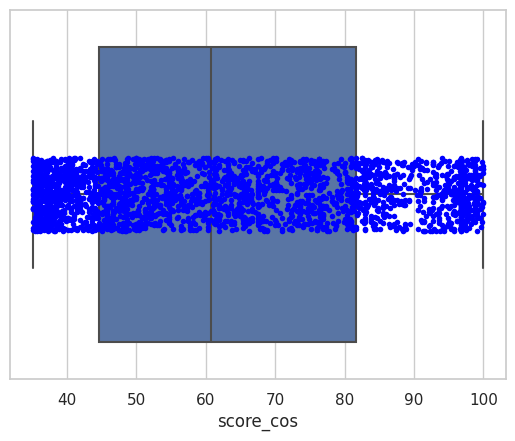

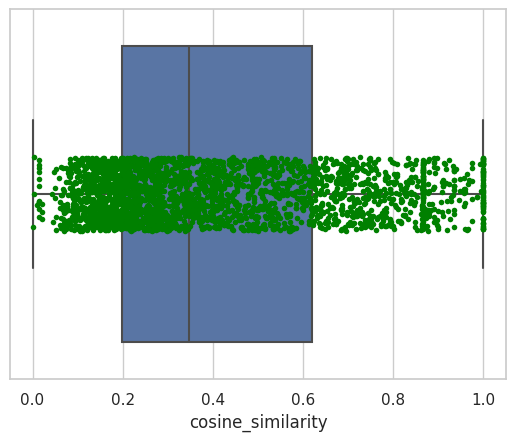

                     z_score_cos  z_cosine_similarity
z_score_cos             1.000000             0.854988
z_cosine_similarity     0.854988             1.000000


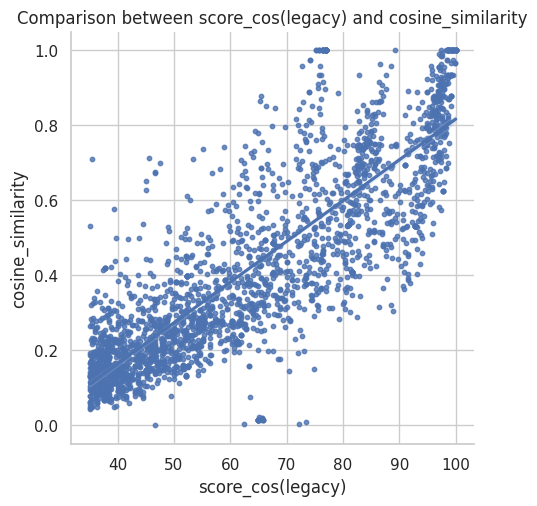

In [8]:
##################################################################################


sns.set(style='whitegrid')

ax = sns.boxplot(data=atall_results,x='score_cos' )  # 'x_column'과 'y_column'은 데이터셋의 컬럼 이름
sns.stripplot(data=atall_results, x='score_cos', color='blue', size=4, jitter=True)

plt.show()

ax = sns.boxplot(data=atall_results, x='cosine_similarity' )  # 'x_column'과 'y_column'은 데이터셋의 컬럼 이름
sns.stripplot(data=atall_results,x='cosine_similarity', color='green', size=4, jitter=True)

plt.show()

####################################################################################
# 기존에 측정했던 코사인 유사도(웹)와 다시 측정한 유사도값과 비교
####################################################################################


score_cos = atall_results['score_cos']
cosine_similarity = atall_results['cosine_similarity']

# # 데이터를 표준화 (z-score 변환)
z_score_cos = zscore(score_cos)
z_cosine_similarity = zscore(cosine_similarity)

# 표준화된 값을 사용하여 새로운 DataFrame 생성
z_scores_df = pd.DataFrame({'z_score_cos': z_score_cos, 'z_cosine_similarity': z_cosine_similarity})

# 표준화된 변수로 상관 계수 계산
corr = z_scores_df.corr(method='pearson')
print(corr)

sns.lmplot(x='score_cos', y='cosine_similarity', data=atall_results, scatter_kws={'s': 10})
plt.xlabel('score_cos(legacy)')
plt.ylabel('cosine_similarity')
plt.title('Comparison between score_cos(legacy) and cosine_similarity')
plt.show()



#######################################################################################
###  피어슨 계수가 0.8을 넘었으므로 아주 강한 양의 증가 관계.
### 기존에 평가했던 방법과 새로 측정해본 코사인 유사도는 양의 관계가 성립한다고 본다.##
#######################################################################################



<ipython-input-9-e3245a35d198>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = subset_df.corr(method='pearson')


                      cosine_similarity  manhattan_similarity  \
cosine_similarity              1.000000              0.752292   
manhattan_similarity           0.752292              1.000000   
euclidean_similarity           0.871321              0.970500   

                      euclidean_similarity  
cosine_similarity                 0.871321  
manhattan_similarity              0.970500  
euclidean_similarity              1.000000  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2606 entries, 0 to 2605
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text_con              2606 non-null   object 
 1   cosine_similarity     2606 non-null   float64
 2   manhattan_similarity  2606 non-null   float64
 3   euclidean_similarity  2606 non-null   float64
dtypes: float64(3), object(1)
memory usage: 101.8+ KB


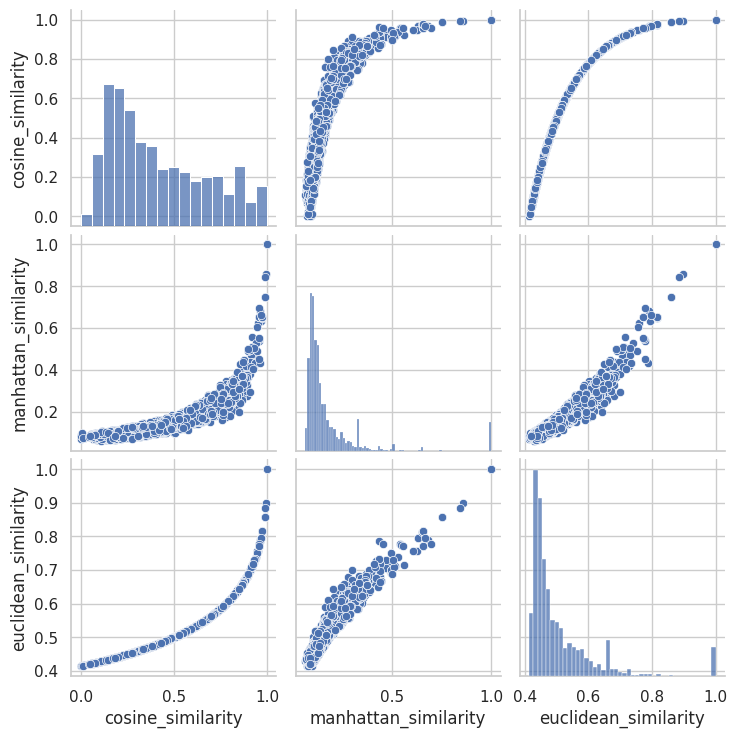

In [9]:


############################################################################
# 두 번째, 다른 유사도 평가방법들 간의 상관관계 확인하고
# 추출한 다른 유사도들 간의 값들을 비교
############################################################################



# merge된 데이터 중 'cosine_similarity' , 'manhattan_similarity', 'euclidean_similarity' 컬럼만 추출

cols = ['text_con', 'cosine_similarity' , 'manhattan_similarity', 'euclidean_similarity']
subset_df = atall_results[cols]
corr = subset_df.corr(method='pearson')
print(corr)

################################################################
# 피어슨 상관계수가 0.75 이상으로 확인
################################################################

subset_df.info()

sns.pairplot(subset_df)



주성분: [0.90246013 0.09645076 0.00108912]


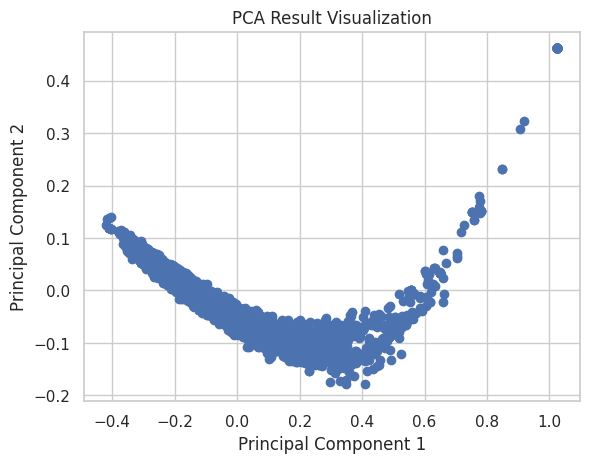

주성분 1의 설명 분산: 0.9025, 누적 설명 분산: 0.9025
주성분 2의 설명 분산: 0.0965, 누적 설명 분산: 0.9989
주성분 3의 설명 분산: 0.0011, 누적 설명 분산: 1.0000


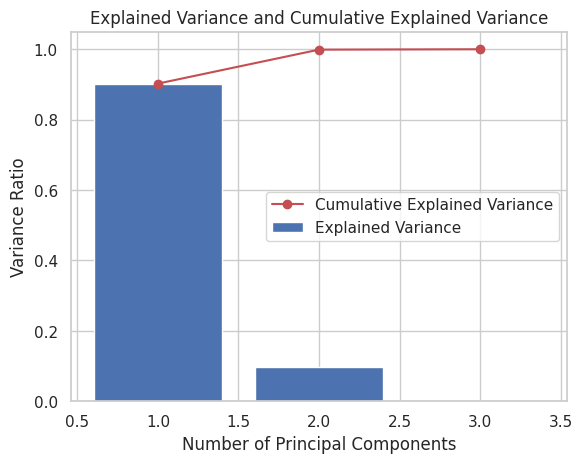

In [11]:
#############################################################################
# 세 개의 유사도 값을 어떻게 하나의 값으로 ... 가능한가? (KISTI에 물어보자) #
# 특성을 남겨서 하나의 값으로하는 주성분 분석                               #                                                 #
#############################################################################

# PCA 모델 생성
pca = PCA()

# 데이터에 PCA 적용
subset_df_without_specific_column = subset_df.drop(['text_con'], axis=1)
pca_result = pca.fit_transform(subset_df_without_specific_column)

# 주성분 결괏값
explained_variance_ratio = pca.explained_variance_ratio_
print("주성분:", explained_variance_ratio)

plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result Visualization')
plt.show()

# 누적 설명 분산 계산
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# 설명 분산 및 누적 설명 분산 출력
for i, ratio in enumerate(explained_variance_ratio):
    print(f"주성분 {i + 1}의 설명 분산: {ratio:.4f}, 누적 설명 분산: {cumulative_explained_variance[i]:.4f}")

# 설명 분산 및 누적 설명 분산 시각화
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='Explained Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', color='r', label='Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Ratio')
plt.legend()
plt.title('Explained Variance and Cumulative Explained Variance')
plt.show()



In [12]:


#pd.set_option("display.max_colwidth", None)

df5 = pd.DataFrame(atall_results)
result = df5[df5['cosine_similarity'] <= 0.01]
print(result)

###########################################################################
# 새로 측정한 코사인 유사도 값이 0.01 이하인 경우가 4건 발견              #
# 고의든 아니든, 점수 부여를 0점으로 할 수 없다.                          #
# 쓴 내용에 맞게 유사도 외 점수를 부여해주는 모델을 만들어 보고자..       #

############################################################################
# 기존의 평갓값으로 입력받은 텍스트에 대해 유사도 값을 예측하는            #
# 회귀분석으로 모델을 만들어보자.                                          #
############################################################################

# PCA의 결괏값을 바탕으로 학습을 시킨 후 점수를 주는 모델은 어떠한가?
# 단순 유사도 측정하는 방법 대신 학습된 모델로 평가해주는 걸 한 번...



      score_cos  score_lcs                                           text_con  \
991       72.22       2.99  피험의자는2023.2.11.0930명장소를모르는곳에서피해자김피해\n에게아들이철수라고...   
1692      62.44       2.61  피회의자는2023.211.13:00년장소를알수없는곳에서피해자나 피해(33세,여)에게...   
1795      46.58       1.20  여행의자는2025211.1300원장소를알수없는곳어서피해자나\n기레(391,에세계KB...   
2292      73.50       3.84  피현의자는2023.2.11.09.30경장소를모르는곳에서피해자김피해에게아들이철수라고하...   

      similarity1  similarity2 classification  cosine_similarity  \
991      0.034199     0.020162      sentence1           0.003830   
1692     0.000000     0.033296      sentence2           0.003990   
1795     0.000000     0.000000      sentence1           0.000000   
2292     0.079872     0.023544      sentence1           0.009756   

      manhattan_similarity  euclidean_similarity  
991               0.089556              0.414679  
1692              0.071192              0.414699  
1795              0.084849              0.414214  
2292              0.095842              0.415403 

In [10]:
#######################################################
#              모델에 적용할 데이터 가공              #
#######################################################

# selectedData = pd.concat([data1, data2],axis=0, ignore_index=False)
# selectedData = selectedData[['text_con', 'sentence2']]
# # pd.set_option('display.expand_frame_repr', False)  # 열 너비를 줄이지 않고 출력
# print(selectedData)
# selectedData = selectedData.rename(columns={'text_con': 'sentence1'})

# tfidf_vectorizer = TfidfVectorizer()
# tfidf_matrix = tfidf_vectorizer.fit_transform(selectedData['sentence1'] + ' ' + selectedData['sentence2'])
# cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)
# selectedData['label'] = cosine_similarities[:, 1]

#new_column_order = ['sentence1', 'sentence2', 'label']
#selectedData = selectedData[new_column_order]


selectedData = atall_results[['text_con', 'classification', 'cosine_similarity']]
print(selectedData)

selectedData = selectedData.rename(columns={'text_con': 'sentence1', 'cosine_similarity': 'score'})

selectedData.loc[selectedData['classification'] == 'sentence1', 'sentence2'] = sentence1
selectedData.loc[selectedData['classification'] == 'sentence2', 'sentence2'] = sentence2

pd.set_option('display.expand_frame_repr', False)  # 열 너비를 줄이지 않고 출력

selectedData = selectedData.drop(columns=['classification'])
new_column_order = ['score', 'sentence1', 'sentence2']
selectedData = selectedData[new_column_order]

print(selectedData)
selectedData.info()




                                               text_con classification  \
0     2023. 2. 11. 09:30경 장소모르는 곳에서 피해자 김피해에게 아들 이철수...      sentence1   
1     2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김피해에게 아...      sentence1   
2     피혐의자는 2023. 2. 11. 09:30경 피해자에게 본인이 아들 이철수이며 카...      sentence1   
3     피혐의자는 2023. 2. 11. 09:30경 피해자에게 본인이 아들 이철수이며 카...      sentence1   
4     피혐의자는 2023. 2. 11. 09:30경 피해자에게 본인이 아들 이철수이며 카...      sentence1   
...                                                 ...            ...   
2601  피혐의자는 2023. 2. 11. 09:30경 아들을 사칭하여 핸드폰이 고장나 연락...      sentence1   
2602  피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...      sentence1   
2603  피혐의자는 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 피해자 나...      sentence2   
2604  피혐의자는 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 피해자 나...      sentence2   
2605  피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자에게...      sentence1   

      cosine_similarity  
0              0.216622  
1              0.612973  
2              0.146442  
3      

In [11]:
# Feature (입력) 및 Label (출력) 열 선택

X = selectedData[['sentence1', 'sentence2']]
X_cleaned = X.applymap(lambda x: x.replace('\t', '').replace('\n', ''))

X_cleaned['score'] = selectedData['score']

# 인덱스를 변경하지 않도록 'ignore_index=True'를 설정
X_cleaned.reset_index(drop=True, inplace=True)

X_train, X_valid = train_test_split(X_cleaned, test_size=0.2, random_state=42)

# 결과 확인
print("훈련 데이터 크기:", X_train.shape[0])
print("검증 데이터 크기:", X_valid.shape[0])

# 훈련 데이터를 TSV 파일로 저장
X_train.to_csv('train_data.tsv', sep='\t', index=False, header=True)

# 검증 데이터를 TSV 파일로 저장
X_valid.to_csv('valid_data.tsv', sep='\t', index=False, header=True)



훈련 데이터 크기: 2084
검증 데이터 크기: 522


In [15]:
# ! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# %cd Mecab-ko-for-Google-Colab/
# ! bash install_mecab-ko_on_colab_light_220429.sh

# NO, IT DID NOT WORK !

In [12]:
# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [17]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [18]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased",
                                          cache_dir='bert_ckpt',
                                          do_lower_case=False)

loading file vocab.txt from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/tokenizer_config.json


loading configuration file config.json from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.33.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}



In [18]:
#random seed 고정

tf.random.set_seed(0)
np.random.seed(0)

# BASE PARAM

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 28 * 2

DATA_IN_PATH = './'
DATA_OUT_PATH = "./"

In [20]:
 # Load Train dataset

TRAIN_STS_DF = os.path.join(DATA_IN_PATH, 'train_data.tsv')
DEV_STS_DF = os.path.join(DATA_IN_PATH,'valid_data.tsv')

train_data = pd.read_csv(TRAIN_STS_DF, header=0, delimiter = '\t', quoting = 3)
dev_data = pd.read_csv(DEV_STS_DF, header=0, delimiter = '\t', quoting = 3)

print("Total # dataset: train - {}, dev - {}".format(len(train_data), len(dev_data)))

Total # dataset: train - 2084, dev - 522


In [21]:

# Bert Tokenizer
# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus


def bert_tokenizer_v2(sent1, sent2, MAX_LEN):

    # For Two setenece input

    encoded_dict = tokenizer.encode_plus(
        text = sent1,
        text_pair = sent2,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.

    )

    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences

    return input_id, attention_mask, token_type_id

In [ ]:
def clean_text(sent):
    sent_clean = re.sub("[^a-zA-Z0-9ㄱ-ㅣ가-힣\\s]", " ", sent)
    return sent_clean

input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []


for sent1, sent2, score in train_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass

train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)
train_inputs = (train_input_ids, train_attention_masks, train_type_ids)
train_data_labels = np.array(data_labels)

In [ ]:
input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in dev_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass

dev_input_ids = np.array(input_ids, dtype=int)
dev_attention_masks = np.array(attention_masks, dtype=int)
dev_type_ids = np.array(token_type_ids, dtype=int)
dev_inputs = (dev_input_ids, dev_attention_masks, dev_type_ids)
dev_data_labels = np.array(data_labels)

In [24]:
print("# train labels: {}, #dev labels: {}".format(len(train_data_labels), len(dev_data_labels)))

# train labels: 2084, #dev labels: 522


In [25]:
class TFBertRegressor(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertRegressor, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.num_class = num_class
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.regressor = tf.keras.layers.Dense(self.num_class,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name="regressor")


    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):

        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.regressor(pooled_output)

        return logits

In [26]:
regression_model = TFBertRegressor(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=1)

loading configuration file config.json from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.33.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 119547
}



loading weights file model.safetensors from cache at bert_ckpt/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/model.safetensors
Loaded 177,853,440 parameters in the TF 2.0 model.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClas

In [27]:
class PearsonCorrelationMetric(tf.keras.metrics.Metric):
    def __init__(self, name="pearson_correlation", **kwargs):
        super(PearsonCorrelationMetric, self).__init__(name=name, **kwargs)
        self.y_true_list = []
        self.y_pred_list = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.reshape(y_pred, shape=[-1])
        self.y_true_list.append(y_true)
        self.y_pred_list.append(y_pred)

    def result(self):
        y_true = tf.concat(self.y_true_list, -1)
        y_pred = tf.concat(self.y_pred_list, -1)
        pearson_correlation = self.pearson(y_true, y_pred)

        return pearson_correlation

    def reset_states(self):
        self.y_true_list = []
        self.y_pred_list = []


    def pearson(self, true, pred):
        m_true = tf.reduce_mean(true)
        m_pred = tf.reduce_mean(pred)
        m_true, m_pred = true-m_true, pred-m_pred
        num = tf.reduce_sum(tf.multiply(m_true, m_pred))
        den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(m_true)), tf.reduce_sum(tf.square(m_pred)))) + 1e-12
        return num / den

In [28]:
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.MeanSquaredError()
metric = PearsonCorrelationMetric()
regression_model.compile(optimizer=optimizer, loss=loss, metrics=[metric], run_eagerly=True)

In [29]:
#학습 진행하기
model_name = "tf2_BERT_KorSTS"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_pearson_correlation', min_delta=0.0001,patience=2,mode='max')
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_pearson_correlation', verbose=1, save_best_only=True, save_weights_only=True,mode='max')

# 학습과 eval 시작
history = regression_model.fit(train_inputs, train_data_labels, epochs=NUM_EPOCHS,
            validation_data = (dev_inputs, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch
print(history.history)

./tf2_BERT_KorSTS -- Folder create complete 

Epoch 1/3


66/66 [==============================] - ETA: 0s - loss: 0.0941 - pearson_correlation: 0.2306

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric PearsonCorrelationMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_pearson_correlation improved from -inf to 0.70451, saving model to ./tf2_BERT_KorSTS/weights.h5
66/66 [==============================] - 108s 1s/step - loss: 0.0941 - pearson_correlation: 0.2306 - val_loss: 0.0421 - val_pearson_correlation: 0.7045
Epoch 2/3
66/66 [==============================] - ETA: 0s - loss: 0.0510 - pearson_correlation: 0.5751
Epoch 2: val_pearson_correlation improved from 0.70451 to 0.75443, saving model to ./tf2_BERT_KorSTS/weights.h5
66/66 [==============================] - 70s 1s/step - loss: 0.0510 - pearson_correlation: 0.5751 - val_loss: 0.0395 - val_pearson_correlation: 0.7544
Epoch 3/3
66/66 [==============================] - ETA: 0s - loss: 0.0441 - pearson_correlation: 0.6432
Epoch 3: val_pearson_correlation improved from 0.75443 to 0.76387, saving model to ./tf2_BERT_KorSTS/weights.h5
66/66 [==============================] - 64s 966ms/step - loss: 0.0441 - pearson_correlation: 0.6432 - val_loss: 0.0282 - val_pearson_correlation: 0.7639
{

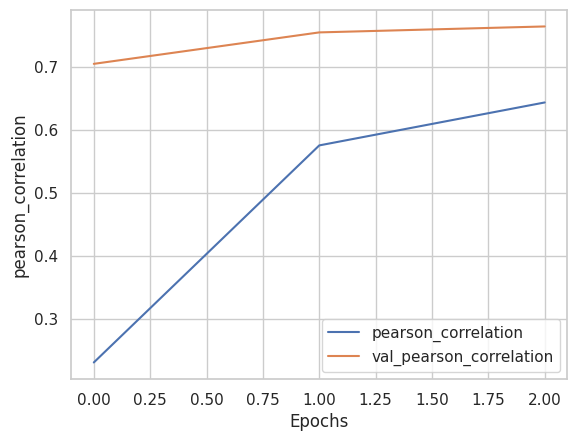

In [30]:
plot_graphs(history, 'pearson_correlation')

In [ ]:
plot_graphs(history, 'loss')

In [31]:
###########################################################################################
#                                                                                         #
#                          테스트 데이터를 어떻게 만들 것인가?                            #
#                                                                                         #
###########################################################################################

# 처음 로드했던 데이터 전체값으로 생성해보고자 한다.
# 물론, 훈련을 위해 사용한 데이터와 동일하므로 정확한 값이 나오지 않을 수.

selectedData2 = pd.concat([data1, data2],axis=0, ignore_index=False)
selectedData2 = selectedData2[['text_con', 'sentence2', 'score_cos']]
# pd.set_option('display.expand_frame_repr', False)  # 열 너비를 줄이지 않고 출력

selectedData2 = selectedData2.rename(columns={'text_con': 'sentence1'})
selectedData2 = selectedData2.rename(columns={'score_cos': 'score'})

new_column_order = ['sentence1', 'sentence2', 'score']
selectedData2 = selectedData2[new_column_order]
print(selectedData2)

# 탭과 케리지리턴값 삭제
X2 = selectedData2[['sentence1', 'sentence2']]
X_cleaned2 = X2.applymap(lambda x: x.replace('\t', '').replace('\n', ''))

X_cleaned2['score'] = selectedData2['score']

# 인덱스를 변경하지 않도록 'ignore_index=True'를 설정
X_cleaned2.reset_index(drop=True, inplace=True)

# 테스트 데이터를 TSV 파일로 저장
X_train.to_csv('test_data.tsv', sep='\t', index=False, header=True)

# # Load Test dataset
TEST_STS_DF = os.path.join(DATA_IN_PATH, 'test_data.tsv')

test_data = pd.read_csv(TEST_STS_DF, header=0, delimiter = '\t', quoting = 3)
test_data.head()


                                              sentence1                                          sentence2  score
0     2023. 2. 11. 09:30경 장소모르는 곳에서 피해자 김피해에게 아들 이철수...  피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...  52.81
1     2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김피해에게 아...  피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...  52.38
2     피혐의자는 2023. 2. 11. 09:30경 피해자에게 본인이 아들 이철수이며 카...  피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...  45.02
3     2023. 2. 20. 09:30경 피해자는 아들로 사칭한 자가 카톡으로 '급히 돈...  피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...  48.91
4     피혐의자는 2023. 2. 11. 09:30 경 장소 미상의 곳에서 아들 ‘철수’ ...  피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...  54.31
...                                                 ...                                                ...    ...
2334  피험의자는 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 피해자 나...  피혐의자는 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 피해자 나...  73.49
2341  피혐의자는 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 자신을 국...  피혐의자는 2023. 2. 11. 13:00경 장소를 알

,sentence1,sentence2,score
0,피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...,피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...,0.532859
1,피혐의자는 2023. 3. 15 09:30경 카카오톡으로 피해자에게 아들 철수라고 ...,피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...,0.299767
2,일체불상의 피혐의자는 2023. 2. 11. 09:30경 불상의 장소에서 피해자 김...,피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...,0.154866
3,피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...,피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...,0.253371
4,피혐의자1은 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 피해자...,피혐의자는 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 피해자 나...,0.545444


In [ ]:

# 위의 소스코드와 적용하는 게 똑같다.

input_ids = []
attention_masks = []
token_type_ids = []
data_labels = []

for sent1, sent2, score in test_data[['sentence1', 'sentence2', 'score']].values:
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer_v2(clean_text(sent1), clean_text(sent2), MAX_LEN)
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(score)
    except Exception as e:
        print(e)
        print(sent1, sent2)
        pass

test_input_ids = np.array(input_ids, dtype=int)
test_attention_masks = np.array(attention_masks, dtype=int)
test_type_ids = np.array(token_type_ids, dtype=int)
test_inputs = (test_input_ids, test_attention_masks, test_type_ids)
test_data_labels = np.array(data_labels)

In [33]:
print("# sents: {}, # labels: {}".format(len(test_input_ids), len(test_data_labels)))

# sents: 2084, # labels: 2084


In [34]:
regression_model.load_weights(checkpoint_path)

results = regression_model.evaluate(test_inputs, test_data_labels, batch_size=512)
print("테스트 손실(loss), 테스트 피어슨 연관성 : ", results)

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric PearsonCorrelationMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


5/5 [==============================] - 7s 1s/step - loss: 0.0263 - pearson_correlation: 0.7984
테스트 손실(loss), 테스트 피어슨 연관성 :  [0.026278279721736908, 0.7984336614608765]


In [13]:
###############################################################################################
#                                    텐서플로 v2로 구현(소스코드 동일)                        #
###############################################################################################

# 모델의 GPT 체크포인트 생성

import wget
import zipfile

wget.download('https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/releases/download/v1.0/gpt_ckpt.zip')

with zipfile.ZipFile('gpt_ckpt.zip') as z:
    z.extractall()

In [14]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [15]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, alpha=0.6)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')

In [19]:
tf.random.set_seed(0)
np.random.seed(0)

BATCH_SIZE = 10
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
SENT_MAX_LEN = 14

DATA_IN_PATH = './'
DATA_OUT_PATH = "./"


In [20]:
# Load Train dataset

TRAIN_STS_DF2 = os.path.join(DATA_IN_PATH, 'train_data.tsv')
DEV_STS_DF2 = os.path.join(DATA_IN_PATH, 'valid_data.tsv')

train_data= pd.read_csv(TRAIN_STS_DF2, header=0, delimiter = '\t', quoting = 3)
dev_data= pd.read_csv(DEV_STS_DF2, header=0, delimiter = '\t', quoting = 3)

train_data2 = train_data.dropna()
dev_data2 = dev_data.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data2), len(dev_data2)))

Total # dataset: train - 2084, dev - 522


In [21]:
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
    return sent_clean

train_data_sents1 = []
train_data_sents2 = []
train_labels = []


for sent1, sent2, score in train_data[['sentence1', 'sentence2', 'score']].values:
    train_tokenized_sent_1 = vocab[tokenizer(clean_text(sent1))]
    train_tokenized_sent_2 = vocab[tokenizer(clean_text(sent2))]
    tokens1 = [vocab[vocab.bos_token]]
    tokens1 += pad_sequences([train_tokenized_sent_1],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens1 += [vocab[vocab.sep_token]]
    tokens1 += pad_sequences([train_tokenized_sent_2],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens1 += [vocab[vocab.eos_token]]
    tokens2 = [vocab[vocab.bos_token]]
    tokens2 += pad_sequences([train_tokenized_sent_2],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens2 += [vocab[vocab.sep_token]]
    tokens2 += pad_sequences([train_tokenized_sent_1],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens2 += [vocab[vocab.eos_token]]

    train_data_sents1.append(tokens1)
    train_data_sents2.append(tokens2)
    train_labels.append(score)

train_data_sents1 = np.array(train_data_sents1, dtype=np.int64)
train_data_sents2 = np.array(train_data_sents2, dtype=np.int64)
train_data_sents = (train_data_sents1, train_data_sents2)
train_data_labels = np.array(train_labels)

In [23]:
dev_data_sents1 = []
dev_data_sents2 = []
dev_labels = []


for sent1, sent2, score in dev_data[['sentence1', 'sentence2', 'score']].values:
    dev_tokenized_sent_1 = vocab[tokenizer(clean_text(sent1))]
    dev_tokenized_sent_2 = vocab[tokenizer(clean_text(sent2))]
    tokens1 = [vocab[vocab.bos_token]]
    tokens1 += pad_sequences([dev_tokenized_sent_1],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens1 += [vocab[vocab.sep_token]]
    tokens1 += pad_sequences([dev_tokenized_sent_2],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens1 += [vocab[vocab.eos_token]]
    tokens2 = [vocab[vocab.bos_token]]
    tokens2 += pad_sequences([dev_tokenized_sent_2],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens2 += [vocab[vocab.sep_token]]
    tokens2 += pad_sequences([dev_tokenized_sent_1],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens2 += [vocab[vocab.eos_token]]

    dev_data_sents1.append(tokens1)
    dev_data_sents2.append(tokens2)
    dev_labels.append(score)

dev_data_sents1 = np.array(dev_data_sents1, dtype=np.int64)
dev_data_sents2 = np.array(dev_data_sents2, dtype=np.int64)
dev_data_sents = (dev_data_sents1, dev_data_sents2)
dev_data_labels = np.array(dev_labels)

In [24]:
 print("Shape of dataset: train - ({}, {}), dev - ({}, {})".format(train_data_sents[0].shape, train_data_sents[1].shape, dev_data_sents[0].shape, dev_data_sents[1].shape))

Shape of dataset: train - ((2084, 31), (2084, 31)), dev - ((522, 31), (522, 31))


In [25]:
class TFGPT2Regressor(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Regressor, self).__init__()

        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.regressor = tf.keras.layers.Dense(self.num_class,
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range),
                                                name="regressior")

    def call(self, inputs):
        outputs1 = self.gpt2(inputs[0])
        outputs2 = self.gpt2(inputs[1])
        outputs = outputs1[0] + outputs2[0]
        pooled_output = outputs[:, -1, :]

        pooled_output = self.dropout(pooled_output)
        logits = self.regressor(pooled_output)

        return logits

In [26]:
regression_model = TFGPT2Regressor('./gpt_ckpt', 1)

loading configuration file ./gpt_ckpt/config.json
Model config GPT2Config {
  "activation_function": "gelu",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "transformers_version": "4.33.0",
  "use_cache": true,
  "vocab_size": 50000
}

loading weights file ./gpt_ckpt/tf_model.h5
All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at

In [27]:
class PearsonCorrelationMetric(tf.keras.metrics.Metric):
    def __init__(self, name="pearson_correlation", **kwargs):
        super(PearsonCorrelationMetric, self).__init__(name=name, **kwargs)
        self.y_true_list = []
        self.y_pred_list = []

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, shape=[-1])
        y_pred = tf.reshape(y_pred, shape=[-1])
        self.y_true_list.append(y_true)
        self.y_pred_list.append(y_pred)

    def result(self):
        y_true = tf.concat(self.y_true_list, -1)
        y_pred = tf.concat(self.y_pred_list, -1)
        pearson_correlation = self.pearson(y_true, y_pred)

        return pearson_correlation

    def reset_states(self):
        self.y_true_list = []
        self.y_pred_list = []


    def pearson(self, true, pred):
        m_true = tf.reduce_mean(true)
        m_pred = tf.reduce_mean(pred)
        m_true, m_pred = true-m_true, pred-m_pred
        r_num = tf.reduce_sum(tf.multiply(m_true, m_pred))
        r_den = tf.sqrt(tf.multiply(tf.reduce_sum(tf.square(m_true)), tf.reduce_sum(tf.square(m_pred)))) + 1e-12
        return r_num / r_den

In [28]:
optimizer = tf.keras.optimizers.Adam(6.25e-5)
loss = tf.keras.losses.MeanSquaredError()
metric = PearsonCorrelationMetric()
regression_model.compile(optimizer=optimizer, loss=loss, metrics=[metric], run_eagerly=True)

In [29]:
model_name = "tf2_gpt_korsts"

earlystop_callback = EarlyStopping(monitor='val_pearson_correlation', min_delta=0.0001,patience=3,mode='max')

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_pearson_correlation', verbose=1, save_best_only=True, save_weights_only=True,mode='max')

history = regression_model.fit(train_data_sents, train_data_labels, epochs=NUM_EPOCHS,
                        validation_data = (dev_data_sents, dev_data_labels),
            batch_size=BATCH_SIZE, callbacks=[earlystop_callback, cp_callback])

./tf2_gpt_korsts -- Folder create complete 

Epoch 1/3


209/209 [==============================] - ETA: 0s - loss: 0.0640 - pearson_correlation: 0.3466

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric PearsonCorrelationMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_pearson_correlation improved from -inf to 0.68880, saving model to ./tf2_gpt_korsts/weights.h5
209/209 [==============================] - 415s 2s/step - loss: 0.0640 - pearson_correlation: 0.3466 - val_loss: 0.0409 - val_pearson_correlation: 0.6888
Epoch 2/3
209/209 [==============================] - ETA: 0s - loss: 0.0412 - pearson_correlation: 0.6442
Epoch 2: val_pearson_correlation improved from 0.68880 to 0.75011, saving model to ./tf2_gpt_korsts/weights.h5
209/209 [==============================] - 314s 2s/step - loss: 0.0412 - pearson_correlation: 0.6442 - val_loss: 0.0407 - val_pearson_correlation: 0.7501
Epoch 3/3
209/209 [==============================] - ETA: 0s - loss: 0.0345 - pearson_correlation: 0.7116
Epoch 3: val_pearson_correlation did not improve from 0.75011
209/209 [==============================] - 305s 1s/step - loss: 0.0345 - pearson_correlation: 0.7116 - val_loss: 0.0303 - val_pearson_correlation: 0.7456


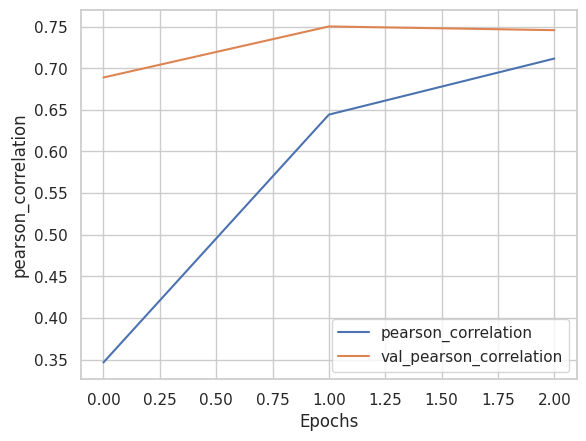

In [30]:
plot_graphs(history, 'pearson_correlation')

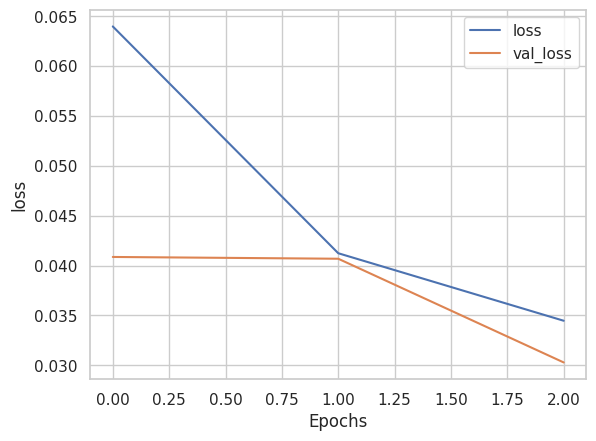

In [31]:
plot_graphs(history, 'loss')

In [32]:
###################################################################################
#                         테스트  (동일)
###################################################################################
# Load Test dataset
TEST_STS_DF = os.path.join(DATA_IN_PATH,'test_data.tsv')

test_data = pd.read_csv(TEST_STS_DF, header=0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()


,sentence1,sentence2,score
0,피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...,피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...,0.532859
1,피혐의자는 2023. 3. 15 09:30경 카카오톡으로 피해자에게 아들 철수라고 ...,피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...,0.299767
2,일체불상의 피혐의자는 2023. 2. 11. 09:30경 불상의 장소에서 피해자 김...,피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...,0.154866
3,피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...,피혐의자는 2023. 2. 11. 09:30경 장소를 알 수 없는 곳에서 피해자 김...,0.253371
4,피혐의자1은 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 피해자...,피혐의자는 2023. 2. 11. 13:00경 장소를 알 수 없는 곳에서 피해자 나...,0.545444


In [33]:
test_data_sents1 = []
test_data_sents2 = []
test_labels = []


for sent1, sent2, score in test_data[['sentence1', 'sentence2', 'score']].values:
    test_tokenized_sent_1 = vocab[tokenizer(clean_text(sent1))]
    test_tokenized_sent_2 = vocab[tokenizer(clean_text(sent2))]
    tokens1 = [vocab[vocab.bos_token]]
    tokens1 += pad_sequences([test_tokenized_sent_1],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens1 += [vocab[vocab.sep_token]]
    tokens1 += pad_sequences([test_tokenized_sent_2],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens1 += [vocab[vocab.eos_token]]
    tokens2 = [vocab[vocab.bos_token]]
    tokens2 += pad_sequences([test_tokenized_sent_2],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens2 += [vocab[vocab.sep_token]]
    tokens2 += pad_sequences([test_tokenized_sent_1],
                            SENT_MAX_LEN,
                            value=vocab[vocab.padding_token],
                            padding='post').tolist()[0]
    tokens2 += [vocab[vocab.eos_token]]

    test_data_sents1.append(tokens1)
    test_data_sents2.append(tokens2)
    test_labels.append(score)

test_data_sents1 = np.array(test_data_sents1, dtype=np.int64)
test_data_sents2 = np.array(test_data_sents2, dtype=np.int64)
test_data_sents = (test_data_sents1, test_data_sents2)
test_data_labels = np.array(test_labels)

In [34]:
print("# sents: {}, # labels: {}".format(len(test_data_sents), len(test_data_labels)))

# sents: 2, # labels: 2084


In [35]:
regression_model.load_weights(checkpoint_path)

results = regression_model.evaluate(test_data_sents, test_data_labels, batch_size=512)
print("test loss, test pearson correlation: ", results)

/usr/local/lib/python3.10/dist-packages/keras/engine/training.py:2448: UserWarning: Metric PearsonCorrelationMetric implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


5/5 [==============================] - 9s 2s/step - loss: 0.0468 - pearson_correlation: 0.7217
test loss, test pearson correlation:  [0.04675339534878731, 0.7217022180557251]
